In [1]:
# import necessary modules
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import path
import matplotlib.pyplot as plt

import time
import xarray as xr

In [2]:
# # https://docs.xarray.dev/en/stable/user-guide/reshaping.html

# array = xr.DataArray(
#     np.random.randn(2, 2, 3), coords=[("time", [0, 3600]),("lon", ["a", "b"]), ("lat", [0, 1, 2])]
# )

# stacked = array.stack(stations=("lon", "lat"))
# stacked


In [3]:
from pyproj import CRS

epsg = 32617 # WGS 84 / UTM zone 17N
crs = CRS.from_epsg(epsg)
crs

<Projected CRS: EPSG:32617>
Name: WGS 84 / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°W and 78°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Ecuador - north of equator. Canada - Nunavut; Ontario; Quebec. Cayman Islands. Colombia. Costa Rica. Cuba. Jamaica. Nicaragua. Panama. United States (USA).
- bounds: (-84.0, 0.0, -78.0, 84.0)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
# logger = setuplog("sfincs_outerbanks_hydromt", log_level=10)
from hydromt_sfincs import SfincsModel
from hydromt_sfincs import utils

ymlfile = r'd:\repos\phd_waves\paper_wave_driven_flooding\02_modelling\Outer_Banks_FloSup\01_data_analysis\dem\new_flosup.yml' 
sf_qt = SfincsModel(data_libs=ymlfile, root="test_clip_ERA5", mode="w+")#, logger=logger)


# for 400 m resolution SnapWave > refinement_level 1
file_name = r'd:\repos\phd_waves\paper_wave_driven_flooding\02_modelling\Outer_Banks_FloSup\02_model_setup\shpfiles\include_snapwave_offshore_plus_coast_refinelevel2.shp'
refine_gdf_lev1 = sf_qt.data_catalog.get_geodataframe(file_name,crs=4326)
new_refine_gdf_lev1 = refine_gdf_lev1.to_crs(crs=crs)

# 200m resolution of FLosup model > refinement_level 2
file_name = r"d:\repos\phd_waves\paper_wave_driven_flooding\02_modelling\Outer_Banks_FloSup\01_data_analysis\from_flosup\include_polygon_flosup_v5_UTM17N_tekal.pol"

refine_gdf_lev2 = utils.polygon2gdf(feats=utils.read_geoms(fn=file_name), crs=crs)

gdf_refinement = gpd.GeoDataFrame(
    {"refinement_level": [1,2,]},
    # {"refinement_level": [5,]},    
    geometry=[new_refine_gdf_lev1.unary_union, refine_gdf_lev2.unary_union,   ],
    crs=crs,
)
    
gdf_refinement
output_file = r'd:\repos\phd_waves\paper_wave_driven_flooding\02_modelling\Outer_Banks_FloSup\02_model_setup\shpfiles\include_polygon_flosup_v5_UTM17N_tekal.geojson'
# gdf_refinement.to_file(output_file, driver='GeoJSON')

sf_qt.setup_grid(
    x0=656551,
    y0=3470589,
    dx=800.0,
    dy=800.0,
    nmax=647,
    mmax=954,
    rotation=40.0,
    epsg=epsg, #WGS 84 / UTM zone 17N
    refinement_polygons=gdf_refinement,
)

Model dir already exists and files might be overwritten: d:\repos\phd_waves\paper_wave_driven_flooding\02_modelling\Outer_Banks_FloSup\02_model_setup\test_clip_ERA5\gis.


Building mesh ...
Refining ...
Time elapsed : 179.51814770698547 s
Finding neighbors ...
Time elapsed : 2.7068405151367188 s
Setting neighbors left and below ...
Time elapsed : 5.028427362442017 s
Getting uv points ...
Time elapsed : 6.779015302658081 s
Making XUGrid ...
Got rid of duplicates in 35.1490 seconds
Made XUGrid in 0.0151 seconds
Time elapsed : 250.59287118911743 s


In [5]:
filename = r'p:\archivedprojects\11206515-flosup2021\01_data\ERA5\ERA5_waves2018.nc'

era5 = xr.open_dataset(filename)
era5


<xarray.Dataset> Size: 273MB
Dimensions:    (longitude: 51, latitude: 51, time: 8760)
Coordinates:
  * longitude  (longitude) float32 204B 270.0 270.5 271.0 ... 294.0 294.5 295.0
  * latitude   (latitude) float32 204B 45.0 44.5 44.0 43.5 ... 21.0 20.5 20.0
  * time       (time) datetime64[ns] 70kB 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    swh        (time, latitude, longitude) float32 91MB ...
    mwd        (time, latitude, longitude) float32 91MB ...
    mwp        (time, latitude, longitude) float32 91MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-03-06 02:54:49 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

### Try cliping ERA5 data to domain:

In [6]:
era5new = era5.copy()
# we need: "hs", "tp", "wd", "ds"
era5new = era5new.rename({'swh': 'hs'})
era5new = era5new.rename({'mwp': 'tp'})
era5new = era5new.rename({'mwd': 'wd'})

# add directional spreading
era5new = era5new.assign(ds=30.0 * xr.ones_like(era5new['hs']))

#  rename
era5new = era5new.set_coords(["longitude", "latitude"])
# ds = ds.rename_vars({"point_hm0":"hs", "point_tp":"tp", "point_wavdir":"wd", "point_dirspr":"ds"})
era5new = era5new.rename({"longitude": "lon", "latitude" : "lat"})#, "stations": "index"})
era5new = era5new.set_coords(["lon", "lat"])

# convert coordinates
tmp = era5new.coords['lon'].values# = era5new.coords['lon'].values - 360 #convert [0-360] to [-180,180]
tmp2 = tmp - 360
era5new.coords['lon'] = tmp2

# Fill NaN values with zero
era5new = era5new.fillna(0)
era5new.attrs['crs'] = 'EPSG:4326'  # Example CRS: WGS84

era5new
# era5new.to_netcdf(r'd:\repos\phd_waves\paper_wave_driven_flooding\02_modelling\Outer_Banks_FloSup\01_data_analysis\ERA5\ERA5_waves2018_rename_added_ds.nc')

<xarray.Dataset> Size: 365MB
Dimensions:  (time: 8760, lat: 51, lon: 51)
Coordinates:
  * lat      (lat) float32 204B 45.0 44.5 44.0 43.5 43.0 ... 21.5 21.0 20.5 20.0
  * time     (time) datetime64[ns] 70kB 2018-01-01 ... 2018-12-31T23:00:00
  * lon      (lon) float32 204B -90.0 -89.5 -89.0 -88.5 ... -66.0 -65.5 -65.0
Data variables:
    hs       (time, lat, lon) float32 91MB 0.0 0.0 0.0 0.0 ... 2.162 2.211 2.244
    wd       (time, lat, lon) float32 91MB 0.0 0.0 0.0 0.0 ... 62.9 61.46 60.1
    tp       (time, lat, lon) float32 91MB 0.0 0.0 0.0 0.0 ... 8.263 8.368 8.542
    ds       (time, lat, lon) float32 91MB 30.0 30.0 30.0 ... 30.0 30.0 30.0
Attributes:
    Conventions:  CF-1.6
    history:      2021-03-06 02:54:49 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...
    crs:          EPSG:4326

In [7]:
era5new.coords['lon'].values

array([-90. , -89.5, -89. , -88.5, -88. , -87.5, -87. , -86.5, -86. ,
       -85.5, -85. , -84.5, -84. , -83.5, -83. , -82.5, -82. , -81.5,
       -81. , -80.5, -80. , -79.5, -79. , -78.5, -78. , -77.5, -77. ,
       -76.5, -76. , -75.5, -75. , -74.5, -74. , -73.5, -73. , -72.5,
       -72. , -71.5, -71. , -70.5, -70. , -69.5, -69. , -68.5, -68. ,
       -67.5, -67. , -66.5, -66. , -65.5, -65. ], dtype=float32)

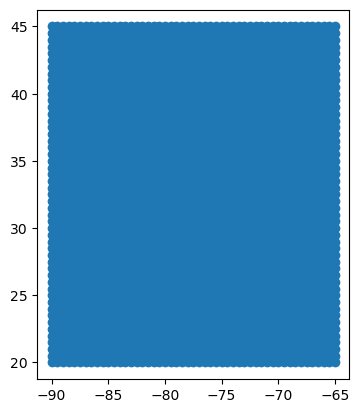

In [8]:
lon = era5new.coords['lon'].values
lat = era5new.coords['lat'].values

[lon2d, lat2d] = np.meshgrid(lon,lat)

lon2dflat = lon2d.flat
lat2dflat = lat2d.flat

# Create a GeoDataFrame from the coordinates
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lon2dflat, lat2dflat), crs=4326)
gdf
# # # Create a GeoDataFrame
gdf.plot()
output_file = r'd:\repos\phd_waves\paper_wave_driven_flooding\02_modelling\Outer_Banks_FloSup\02_model_setup\shpfiles\ERA5_points.geojson'
# gdf.to_file(output_file, driver='GeoJSON')

In [9]:
file_name = r'd:\repos\phd_waves\paper_wave_driven_flooding\02_modelling\Outer_Banks_FloSup\01_data_analysis\ERA5\select_era5_points.shp'
include_era5 = sf_qt.data_catalog.get_geodataframe(file_name,crs=4326)
include_era5

,id,geometry
0,None,"POLYGON ((-80.83135 31.72468, -80.38588 31.809..."


In [10]:
era5new

<xarray.Dataset> Size: 365MB
Dimensions:  (time: 8760, lat: 51, lon: 51)
Coordinates:
  * lat      (lat) float32 204B 45.0 44.5 44.0 43.5 43.0 ... 21.5 21.0 20.5 20.0
  * time     (time) datetime64[ns] 70kB 2018-01-01 ... 2018-12-31T23:00:00
  * lon      (lon) float32 204B -90.0 -89.5 -89.0 -88.5 ... -66.0 -65.5 -65.0
Data variables:
    hs       (time, lat, lon) float32 91MB 0.0 0.0 0.0 0.0 ... 2.162 2.211 2.244
    wd       (time, lat, lon) float32 91MB 0.0 0.0 0.0 0.0 ... 62.9 61.46 60.1
    tp       (time, lat, lon) float32 91MB 0.0 0.0 0.0 0.0 ... 8.263 8.368 8.542
    ds       (time, lat, lon) float32 91MB 30.0 30.0 30.0 ... 30.0 30.0 30.0
Attributes:
    Conventions:  CF-1.6
    history:      2021-03-06 02:54:49 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...
    crs:          EPSG:4326

In [11]:
# Check if points are inside the polygon
gdf['inside_polygon'] = gdf.within(include_era5.unary_union)

# print(gdf['inside_polygon'] == True)
# Spatial join to check which points are within the polygon
points_within_polygon = gpd.sjoin(gdf, include_era5, how="inner", op='within')
points_within_polygon

# index = points_within_polygon.index
# index
xpoint = points_within_polygon.geometry.centroid.x
ypoint = points_within_polygon.geometry.centroid.y

# Convert the geometry column of the GeoDataFrame to a list
geometry_list = points_within_polygon['geometry'].tolist()
geometry_list

[<POINT (-75.5 37)>,
 <POINT (-75 36.5)>,
 <POINT (-75 36)>,
 <POINT (-75 35.5)>,
 <POINT (-75.5 35)>,
 <POINT (-76 34.5)>,
 <POINT (-77 34)>,
 <POINT (-76.5 34)>,
 <POINT (-78 33.5)>,
 <POINT (-77.5 33.5)>,
 <POINT (-79 33)>,
 <POINT (-78.5 33)>,
 <POINT (-79.5 32.5)>,
 <POINT (-80 32)>,
 <POINT (-80.5 31.5)>]

(31.0, 38.0)

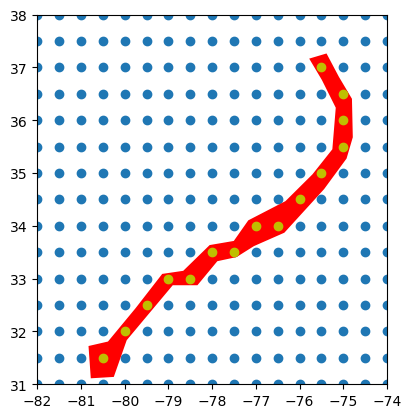

In [12]:
fig, ax = plt.subplots()
gdf.plot(ax=ax)
include_era5.plot(ax=ax, color="r", ls="--")#, facealpha=0.5)
ax.scatter(xpoint, ypoint, color='y')

ax.set_xlim(-82, -74)
ax.set_ylim(31, 38)

<xarray.Dataset> Size: 365MB
Dimensions:  (time: 8760, lat: 51, lon: 51)
Coordinates:
  * lat      (lat) float32 204B 45.0 44.5 44.0 43.5 43.0 ... 21.5 21.0 20.5 20.0
  * time     (time) datetime64[ns] 70kB 2018-01-01 ... 2018-12-31T23:00:00
  * lon      (lon) float32 204B -90.0 -89.5 -89.0 -88.5 ... -66.0 -65.5 -65.0
Data variables:
    hs       (time, lat, lon) float32 91MB nan nan nan nan ... nan nan nan nan
    wd       (time, lat, lon) float32 91MB nan nan nan nan ... nan nan nan nan
    tp       (time, lat, lon) float32 91MB nan nan nan nan ... nan nan nan nan
    ds       (time, lat, lon) float32 91MB nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2021-03-06 02:54:49 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...
    crs:          EPSG:4326


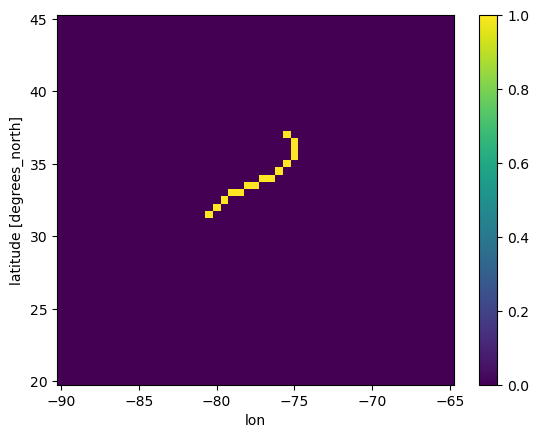

In [13]:
# Create a mask to filter out the specific points
mask = xr.DataArray(False, dims=("lon", "lat"), coords={"lon": era5new['lon'], "lat": era5new['lat']})

for point in geometry_list:
    x_coordinate = point.x
    y_coordinate = point.y
    
    # mask.loc[x_coordinate,y_coordinate] = True
    mask.loc[{"lon":x_coordinate, "lat":y_coordinate}] = True

# Apply the mask to extract the specific points
selected_points = era5new.where(mask, drop=False)

print(selected_points)
# print(mask)
mask.plot(x='lon',y='lat')


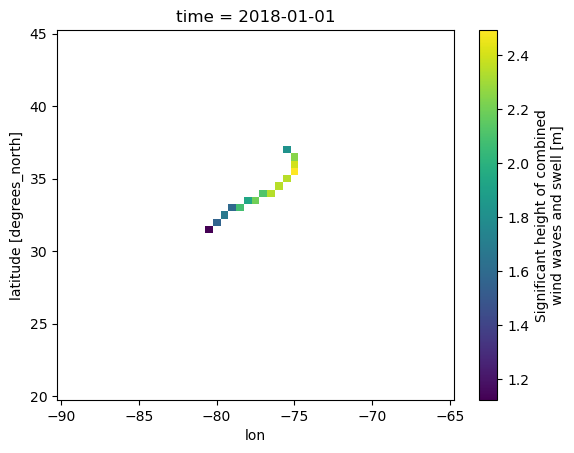

In [14]:
selected_points['hs'][0,:,:].plot()

In [15]:
# stack 2D grid into 1D 'stations'
stacked = selected_points.stack(stations=("lon", "lat"))
stacked


<xarray.Dataset> Size: 365MB
Dimensions:   (time: 8760, stations: 2601)
Coordinates:
  * time      (time) datetime64[ns] 70kB 2018-01-01 ... 2018-12-31T23:00:00
  * stations  (stations) object 21kB MultiIndex
  * lon       (stations) float32 10kB -90.0 -90.0 -90.0 ... -65.0 -65.0 -65.0
  * lat       (stations) float32 10kB 45.0 44.5 44.0 43.5 ... 21.0 20.5 20.0
Data variables:
    hs        (time, stations) float32 91MB nan nan nan nan ... nan nan nan nan
    wd        (time, stations) float32 91MB nan nan nan nan ... nan nan nan nan
    tp        (time, stations) float32 91MB nan nan nan nan ... nan nan nan nan
    ds        (time, stations) float32 91MB nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2021-03-06 02:54:49 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...
    crs:          EPSG:4326

In [16]:
#remove filtered out stations
ds_cleaned = stacked.dropna(dim='stations', how='all')
ds_cleaned


<xarray.Dataset> Size: 2MB
Dimensions:   (time: 8760, stations: 15)
Coordinates:
  * time      (time) datetime64[ns] 70kB 2018-01-01 ... 2018-12-31T23:00:00
  * stations  (stations) object 120B MultiIndex
  * lon       (stations) float32 60B -80.5 -80.0 -79.5 ... -75.0 -75.0 -75.0
  * lat       (stations) float32 60B 31.5 32.0 32.5 33.0 ... 35.0 36.5 36.0 35.5
Data variables:
    hs        (time, stations) float32 526kB 1.124 1.56 1.679 ... 1.306 1.53
    wd        (time, stations) float32 526kB 59.68 53.17 53.89 ... 153.9 160.5
    tp        (time, stations) float32 526kB 6.724 6.238 6.143 ... 5.347 5.323
    ds        (time, stations) float32 526kB 30.0 30.0 30.0 ... 30.0 30.0 30.0
Attributes:
    Conventions:  CF-1.6
    history:      2021-03-06 02:54:49 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...
    crs:          EPSG:4326

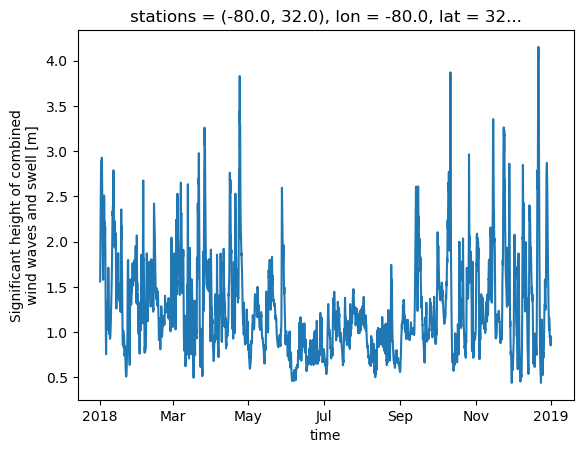

In [17]:
ds_cleaned['hs'][:,1].plot()

In [18]:
# reset_index()
ds_cleaned.reset_index('stations')

ds_reset = ds_cleaned.reset_index('stations')
ds_reset

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 8760, stations: 15)
Coordinates:
  * time     (time) datetime64[ns] 70kB 2018-01-01 ... 2018-12-31T23:00:00
    lon      (stations) float32 60B -80.5 -80.0 -79.5 ... -75.0 -75.0 -75.0
    lat      (stations) float32 60B 31.5 32.0 32.5 33.0 ... 35.0 36.5 36.0 35.5
Dimensions without coordinates: stations
Data variables:
    hs       (time, stations) float32 526kB 1.124 1.56 1.679 ... 1.306 1.53
    wd       (time, stations) float32 526kB 59.68 53.17 53.89 ... 153.9 160.5
    tp       (time, stations) float32 526kB 6.724 6.238 6.143 ... 5.347 5.323
    ds       (time, stations) float32 526kB 30.0 30.0 30.0 ... 30.0 30.0 30.0
Attributes:
    Conventions:  CF-1.6
    history:      2021-03-06 02:54:49 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...
    crs:          EPSG:4326

In [19]:
# set_spatial_dims

ds_reset = ds_reset.rename({'lon': 'x'})
ds_reset = ds_reset.rename({'lat': 'y'})
ds_reset


<xarray.Dataset> Size: 2MB
Dimensions:  (time: 8760, stations: 15)
Coordinates:
  * time     (time) datetime64[ns] 70kB 2018-01-01 ... 2018-12-31T23:00:00
    x        (stations) float32 60B -80.5 -80.0 -79.5 ... -75.0 -75.0 -75.0
    y        (stations) float32 60B 31.5 32.0 32.5 33.0 ... 35.0 36.5 36.0 35.5
Dimensions without coordinates: stations
Data variables:
    hs       (time, stations) float32 526kB 1.124 1.56 1.679 ... 1.306 1.53
    wd       (time, stations) float32 526kB 59.68 53.17 53.89 ... 153.9 160.5
    tp       (time, stations) float32 526kB 6.724 6.238 6.143 ... 5.347 5.323
    ds       (time, stations) float32 526kB 30.0 30.0 30.0 ... 30.0 30.0 30.0
Attributes:
    Conventions:  CF-1.6
    history:      2021-03-06 02:54:49 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...
    crs:          EPSG:4326

In [20]:
# save:
file_name = r'd:\repos\phd_waves\paper_wave_driven_flooding\02_modelling\Outer_Banks_FloSup\01_data_analysis\ERA5\ERA5_waves2018_rename_added_ds_cleaned.nc'
ds_reset.to_netcdf(file_name)


### Actually write data now!

In [21]:
sf_qt.config["tref"] = "20180904 000000"
sf_qt.config["tstart"] = "20180910 152325"
sf_qt.config["tstop"] = "20180928 190000"

In [22]:
# ds_reprojected = ds_reset.rio.reproject(crs)
# ds_reset.raster.to_crs(self.crs)

In [23]:
df_ts = ds_reset.transpose(..., ds_reset.vector.index_dim).to_dataframe()
gdf_locs = ds_reset.vector.to_gdf()
gdf_locs2 = gdf_locs.copy()
gdf_locs2 = gdf_locs2.to_crs(crs)   
gdf_locs2
# crs

,geometry
stations,
0,POINT (547482.436 3485124.900)
1,POINT (594457.463 3540872.531)
2,POINT (640915.611 3596850.345)
3,POINT (686847.223 3653063.504)
4,POINT (733569.963 3654063.335)
5,POINT (778706.266 3710748.658)
6,POINT (825178.421 3712205.182)
7,POINT (869504.584 3769375.557)
8,POINT (915726.460 3771296.368)


In [28]:
sf_qt.setup_wave_forcing(ds_reset)


In [29]:
sf_qt.write()

In [26]:
# # sf_qt.setup_wave_forcing(geodataset = 'era5_waves_2018_rename')

# data_era5 = r'd:\repos\phd_waves\paper_wave_driven_flooding\02_modelling\Outer_Banks_FloSup\01_data_analysis\ERA5\ERA5_waves2018_rename_added_ds.nc'
# ds =  xr.open_mfdataset(data_era5)

# ds = ds.set_coords(["longitude", "latitude"])
# # ds = ds.rename_vars({"point_hm0":"hs", "point_tp":"tp", "point_wavdir":"wd", "point_dirspr":"ds"})
# ds = ds.rename({"longitude": "lon", "latitude" : "lat"})#, "stations": "index"})
# ds = ds.set_coords(["lon", "lat"])
# #ds = ds.set_index(stations = ["station_x", "station_y"], append = True )

# lon = era5.coords['longitude'].values - 360 #convert [0-360] to [-180,180]
# lat = era5.coords['latitude'].values

# [lon2d, lat2d] = np.meshgrid(lon,lat)

# lon2dflat = lon2d.flat
# lat2dflat = lat2d.flat

# ds
# #TODO: try as flat 1D arrays > first selected within range? lat/lon/time
# # ds
# # sf_qt.setup_wave_forcing(ds)



In [27]:
# # fn = r'd:\repos\phd_waves\paper_wave_driven_flooding\02_modelling\LaJola\01_data_analysis\ndbc_station46254_2015_nearshore_clean_smooth.nc'
# fn = r'p:\archivedprojects\11206515-flosup2021\01_data\ERA5\ERA5_waves2018.nc'

# ndbc_deep = xr.open_dataset(fn)

# ndbc_deep

# # x&y-locations:
# x = ndbc_deep.station_x
# y = ndbc_deep.station_y

# # add to Geopandas dataframe as needed by HydroMT
# pnts = gpd.points_from_xy(x, y)
# index = [1]  # NOTE that the index should start at one
# bnd = gpd.GeoDataFrame(index=index, geometry=pnts, crs=4326)
# bnd


# # Wanted values:
# hs = ndbc_deep.hs #[[5.0], [5.0]]
# tp = ndbc_deep.tp #[[10.0], [10.0]]
# dir = ndbc_deep.mwd #[[290.0], [290.0]]

# # Assumption wave spreading
# s = 20.0
# sigma = np.sqrt(2 / (s + 1)) / np.pi * 180.0 #s  =    20 > to degress

# # ds = hs.copy()
# # ds = ds.where(ds > 0, sigma)
# ds = sigma * np.ones_like(hs)
# # ds.values = sigma

# ds
# # ds['hs'].values = sigma
# # # ds = sigma * np.ones_like(hs) #[[sigma], [sigma]]
# time = ndbc_deep.time# [0, 99999]

# df_hs = pd.DataFrame(index= time, data = hs)
# df_tp = pd.DataFrame(index= time, data = tp)
# df_dir = pd.DataFrame(index= time, data = dir)
# df_ds = pd.DataFrame(index= time, data = ds)

# list_df = [df_hs, df_tp, df_dir, df_ds] 

# list_df

# sf_qt.setup_wave_forcing(timeseries = list_df, locations= bnd)
